##### 讀入資料

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # 讓背景變灰, 格線變白
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # matplotlib顯示中文 mac os, https://www.code-learner.com/how-to-solve-mac-system-python-matplotlib-library-chinese-gibberish-problem/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # matplotlib顯示中文 windows
plt.rcParams['axes.unicode_minus'] = False # matplotlib顯示減號
import pandas as pd
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

mrt = pd.read_csv(f"MRT_cooked_data/cooked_202205.csv")
stations = list(mrt['站名'].unique())
mrt['時段'].unique()

array([ 0,  1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23], dtype=int64)

In [2]:
monday_date = 16
week = []
prefix = '2022-05-'
for i in range(7):
    date = monday_date + i
    if date >= 10:
        date = str(date)
    else:
        date = '0'+str(date)
    week.append(prefix + date)
week

['2022-05-16',
 '2022-05-17',
 '2022-05-18',
 '2022-05-19',
 '2022-05-20',
 '2022-05-21',
 '2022-05-22']

##### 每天凌晨2,3,4點捷運沒開 把凌晨2,3,4點的人流補上0

In [3]:
def insert_234_oclock(df):
    zeros = [0] * df.shape[0] # 插入 119 個 0
    
    for i in range(7): # 7表示一週七天
        for j in range(3): # 3表示凌晨2,3,4點這三個小時
            idx = (24*i)+2 # +2是為了從每天第 2 個小時開始插入 (0, 1, "2", "3", "4", 5, 6...)
            df.insert(loc=idx, column='{}_{}'.format(i,j), value=zeros)
            
    rename_cols = [*range(168)]
    df.columns = rename_cols   

    return df

##### 一周進站向量的 dataframe

In [4]:
stn_in_all = pd.DataFrame()
for station in stations:
    stn_in = mrt[ (mrt['日期'].isin(week)) & (mrt['站名']==station) ][['進站']]
    stn_in.columns = [station+'IN']
    stn_in = stn_in.T
    stn_in.columns = [*range(147)]
    stn_in_all = pd.concat([stn_in_all,stn_in])
    
stn_in_all = insert_234_oclock(stn_in_all)

# 對 row 做 min max scale
scaler=MinMaxScaler()
stn_in_all_scaled = pd.DataFrame(scaler.fit_transform(stn_in_all.T).T, index=stn_in_all.index, columns=stn_in_all.columns).round(4)

##### 一周出站向量的 dataframe

In [5]:
stn_out_all = pd.DataFrame()
for station in stations:
    stn_out = mrt[ (mrt['日期'].isin(week)) & (mrt['站名']==station) ][['出站']]
    stn_out.columns = [station+'OUT']
    stn_out = stn_out.T
    stn_out.columns = [*range(147)]
    stn_out_all = pd.concat([stn_out_all,stn_out])

stn_out_all = insert_234_oclock(stn_out_all)
    
# 對 row 做 min max scale
scaler=MinMaxScaler()
stn_out_all_scaled = pd.DataFrame(scaler.fit_transform(stn_out_all.T).T, index=stn_out_all.index, columns=stn_out_all.columns).round(4)

##### cluster_mean() 取得平均線, cluster_lines() 取得每條線

In [6]:
# 取得各 cluster 的平均線
def cluster_mean(df,cluster): 
    df = df[df['cluster']==cluster]
    result = df.iloc[:,:-1].mean() # -1 去掉 cluster 欄位
    return result

# 取得 cluster 中的每條線
def cluster_lines(df,cluster):
    return df[df['cluster']==cluster].iloc[:,:-1] # -1 去掉 cluster 欄位

##### draw_clusters_in_subplot() 把每個cluster畫在同一張subplot上

In [7]:
def draw_clusters_in_subplot(stn_in_cluster): # stn_in_cluster 是完整的 dataframe, 包含每個 cluster
    x_labels = [*range(168)]

    cluster_count = stn_in_cluster['cluster'].unique().shape[0]

    fig, ax = plt.subplots(nrows=cluster_count, ncols=1, figsize=(15, 12))

    plt.setp(ax, xticks=np.arange(0, 168, 24), yticks=np.arange(0,1,0.2))

    for c in stn_in_cluster['cluster'].unique():
        # 顯示 subplot title
        ax[c].set_title(f'Cluster {c}', fontsize=12)
        
        # 畫出該 cluster 的每條線
        for i in range( cluster_lines(stn_in_cluster,c).shape[0] ):
            ax[c].plot(x_labels, cluster_lines(stn_in_cluster,c).iloc[i], color='lightgrey' )
    
        # 畫出該 cluster 的平均線    # color code 網站 -> https://www.computerhope.com/htmcolor.htm
        ax[c].plot(x_labels, cluster_mean(stn_in_cluster,c), color='#357EC7',label='Mean') # 畫平均線

        # 畫出每天的分隔虛線
        weekday = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
        for i in range(0,168,24): 
            ax[c].axvline(x=i, color='#3A3B3C', linestyle='--',linewidth=1.2)
            ax[c].text(i+10,-0.2,weekday[int(i/24)],color='k')
        ax[c].axvline(x=167, color='#3A3B3C', linestyle='--',linewidth=1)
    
        # 不顯示 x ticks
        ax[c].tick_params(
                        axis='x',          # 針對x軸
                        which='both',      # 針對 both major ticks 和 minor ticks 
                        bottom=False,      # 不顯示 bottom ticks 
                        top=False,         # 不顯示 top ticks 
                        labelbottom=False)
    
        # 顯示 legned 在右上角
        ax[c].legend(loc='upper right')
    
    fig.tight_layout()

##### draw_one_cluster() 一個cluster畫一張plot
##### draw_each_cluster() 用迴圈對各群去 draw_one_cluster()

In [16]:
def draw_one_cluster(one_cluster, c): # one_cluster 表示一個 cluster 的 dataframe, c 表示第幾個 cluster
    x_labels = [*range(168)]
    plt.figure(figsize=(15, 2.5))

    xticks=np.arange(0, 168, 24)
    yticks=np.arange(0,1,0.2)
    plt.title(f'Cluster {c}', fontsize=12)

    # 畫出該 cluster 的每條線
    for i in range( cluster_lines(one_cluster,c).shape[0] ):
        plt.plot(x_labels, cluster_lines(one_cluster,c).iloc[i], color='lightgrey' )

    # 畫出該 cluster 的平均線    # color code 網站 -> https://www.computerhope.com/htmcolor.htm
    plt.plot(x_labels, cluster_mean(one_cluster,c), color='#357EC7',label='Mean') # 畫平均線

    # 畫出每天的分隔虛線
    weekday = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    for i in range(0,168,24): 
        plt.axvline(x=i, color='#3A3B3C', linestyle='--',linewidth=1.2)
        plt.text(i+10,-0.2,weekday[int(i/24)],color='k')
    plt.axvline(x=167, color='#3A3B3C', linestyle='--',linewidth=1)
    
    # 不顯示 x ticks
    plt.tick_params(
                    axis='x',          # 針對x軸
                    which='both',      # 針對 both major ticks 和 minor ticks 
                    bottom=False,      # 不顯示 bottom ticks 
                    top=False,         # 不顯示 top ticks 
                    labelbottom=False)
    
    # 顯示 legned 在右上角
    plt.legend(loc='upper right')
    
    # 顯示 cluster 包含哪些站
    txt1 = f"{one_cluster.index.shape[0]} stations in Cluster {c}\n"
    txt2 = ""
    for idx,stn in enumerate(one_cluster.index):
        txt2 += stn
        if (idx+1)%15==0:
            txt2+='\n'
    txt2 = txt2.replace('IN',', ').replace('OUT',', ')
    plt.figtext(0.13,-0.45,txt1+txt2,size=12)

def draw_each_cluster(df):
    for c in range( df['cluster'].unique().shape[0] ):
        draw_one_cluster(df[df['cluster']==c], c)

##### list_stn_cluster() 列出各 cluster 包含哪些站

In [9]:
def list_stn_cluster(df):
    for c in range( df['cluster'].unique().shape[0] ):
        print(f"cluster {c}\n")
        print(f"{df[df['cluster']==c].index.shape[0]} stations in cluster {c}\n")
        txt = ""
        for idx,stn in enumerate(df[df['cluster']==c].index):
            txt += stn
        txt = txt.replace('IN',', ').replace('OUT',', ')
        print(txt)
        print('--------------------\n')

### 進站分群

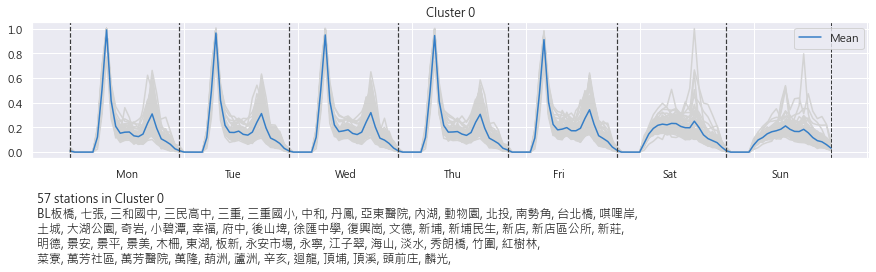

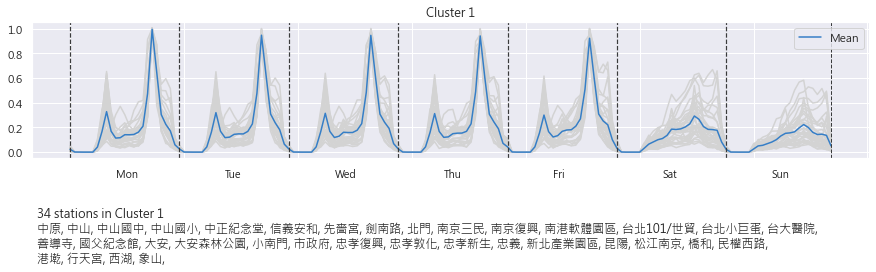

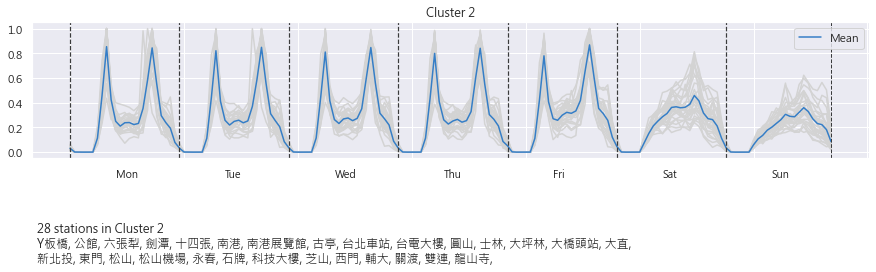

In [17]:
k=3
kmeans_in = KMeans(n_clusters=k, random_state=0)
kmeans_in = kmeans_in.fit(stn_in_all_scaled)
labels_in = kmeans_in.predict(stn_in_all_scaled)
centroids_in = kmeans_in.cluster_centers_

# 新增一欄 cluster 欄位在最後面
labels_in = pd.DataFrame(labels_in, index=stn_in_all_scaled.index, columns=['cluster']) # labels_in 為 cluster 欄位
stn_in_cluster = pd.concat( [stn_in_all_scaled,labels_in], axis=1 ) # 把 cluster 欄位與 stn_in_all_scaled 合併

draw_each_cluster(stn_in_cluster) #每群各畫一張圖
# list_stn_cluster(stn_in_cluster) # 列出每個cluster包含哪些站
# draw_clusters_in_subplot(stn_in_cluster) # 每群畫在同一張圖 (一個群一個subplot)

### 選擇群數: 進站 silhouette score 

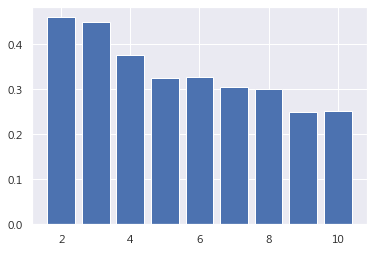

[0.4592552906354544, 0.4477019055003747, 0.37568887775678017, 0.32424246874775714, 0.32773813874974267, 0.3034508285687392, 0.3006570188232059, 0.24819155140647586, 0.2501877414513278]


In [11]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(stn_in_all_scaled)
    labels_in = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(stn_in_all_scaled, labels_in)
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

### 出站分群

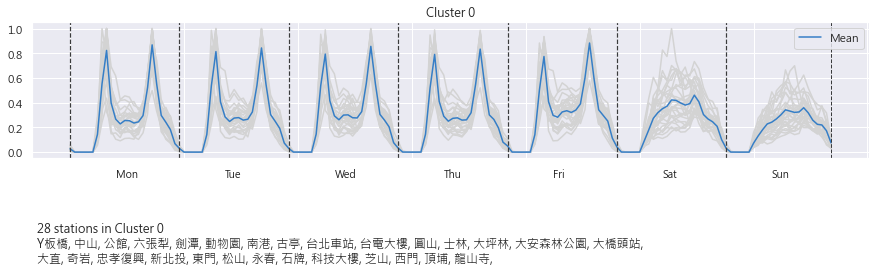

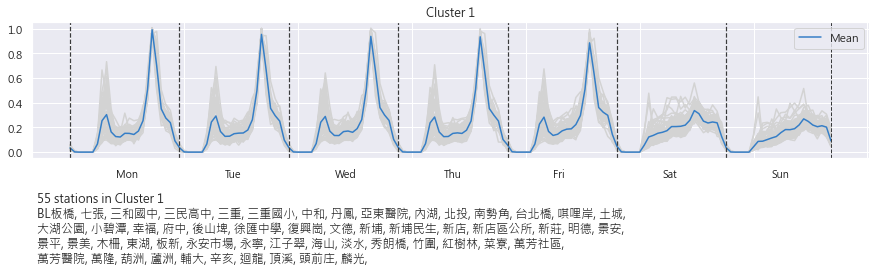

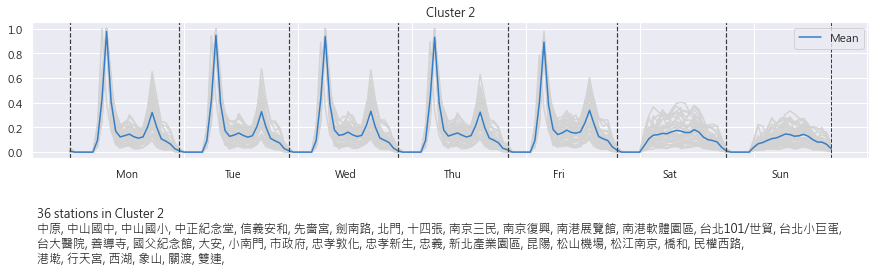

In [18]:
k=3
kmeans_out = KMeans(n_clusters=k, random_state=0)
kmeans_out = kmeans_out.fit(stn_out_all_scaled)
labels_out = kmeans_out.predict(stn_out_all_scaled)
centroids_out = kmeans_out.cluster_centers_

# 新增一欄 cluster 欄位在最後面
labels_out = pd.DataFrame(labels_out, index=stn_out_all_scaled.index, columns=['cluster']) # labels_out 為 cluster 欄位
stn_out_cluster = pd.concat( [stn_out_all_scaled,labels_out], axis=1 ) # 把 cluster 欄位與 stn_out_all_scaled 合併

draw_each_cluster(stn_out_cluster) # 每群各畫一張圖
# list_stn_cluster(stn_out_cluster) # 列出每個cluster包含哪些站
# draw_clusters_in_subplot(stn_out_cluster) # 每群畫在同一張圖 (一個群一個subplot)

### 選擇群數: 出站 silhouette score

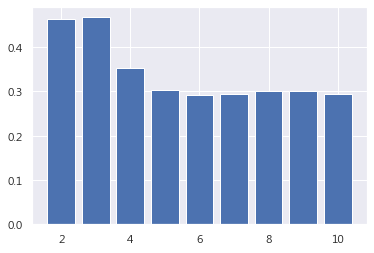

[0.46350793640010746, 0.46767765800305294, 0.3540517890432616, 0.3032408026087755, 0.2910252264684517, 0.29433695428189705, 0.30025874078746023, 0.30152988206287745, 0.29507155366267496]


In [13]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(stn_out_all_scaled)
    labels_in = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(stn_out_all_scaled, labels_in)
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)